In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F
from tqdm import tqdm
import os
import re
import sys
import time
import logging
import tempfile
from collections import Counter
from typing import List, Tuple
from tqdm import tqdm

import numpy as np
import pandas as pd

import rdkit
from rdkit import Chem
from rdkit.Chem import MolFromSmiles, MolToSmiles, CanonSmiles

import deepchem as dc
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import cross_validate
from scipy.sparse import csr_matrix, lil_matrix

import atomInSmiles as ais
import json

In [17]:
# This vocab only focus in characters not in pairs.
class CreateVocab:
    def __init__(self, datasets):
        """
        Initialize the CreateVocab object with multiple datasets.

        :param datasets: List of datasets (strings) to build the vocabulary from.
        """
        self.stoi = {}
        self.itos = {}
        self.build_vocab(datasets)

    def build_vocab(self, datasets):
        """
        Builds the vocabulary from the given datasets.

        :param datasets: List of datasets (strings) to build the vocabulary from.
        """
        all_text = ''.join(datasets)  # Concatenate all datasets
        unique_chars = sorted(set(all_text))  # Extract unique characters

        self.stoi = {char: idx for idx, char in enumerate(unique_chars)}
        self.itos = {idx: char for idx, char in enumerate(unique_chars)}

    def encode(self, text):
        """
        Encodes a given text into a list of indices.

        :param text: String to be encoded.
        :return: List of indices corresponding to the characters in the text.
        """
        return [self.stoi[char] for char in text]

    def decode(self, indices):
        """
        Decodes a list of indices into a string.

        :param indices: List of indices to be decoded.
        :return: Decoded string.
        """
        return ''.join(self.itos[idx] for idx in indices)


def preprocess_smiles(smiles):
    """
    Preprocesses a given SMILES string by adding padding and start and end tokens.

    :param smiles: SMILES string to be preprocessed.
    :return: Preprocessed SMILES string.
    """
    text = [str(i) + "*" for i in smiles]
    text = str(text)[1:-1]
    return text

# Load and process datasets
smile_1 = pd.read_csv('smile_1.csv')['smiles']
smile_2 = pd.read_csv('smile_2.csv')['smiles']
smile_3 = pd.read_csv('smile_3.csv')['canonical_smiles']

processed_smile_1 = preprocess_smiles(smile_1)
processed_smile_2 = preprocess_smiles(smile_2)
processed_smile_3 = preprocess_smiles(smile_3)

# Combine processed datasets
combined_text = processed_smile_1 + processed_smile_2 + processed_smile_3

# Create vocabulary
vocab = CreateVocab([combined_text])

# Now vocab.stoi and vocab.itos are your dictionaries



In [66]:
encoded_text = vocab.encode(text)

# Train and test splits
data = torch.tensor(encoded_text, dtype=torch.long)
n = int(0.9 * len(data))  # 90% for training, rest for validation
train_data = data[:n]
val_data = data[n:]

In [67]:
# hyperparameters
batch_size = 16 # how many independent sequences will we process in parallel?
block_size = 32 # what is the maximum context length for predictions?
max_iters = 350
eval_interval = 10
learning_rate = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 100
n_embd = 64
n_head = 4
n_layer = 4
dropout = 0.0
# ------------

torch.manual_seed(1337)
vocab_size = len(vocab.stoi)

def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y

@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B,T,C = x.shape
        k = self.key(x)   # (B,T,C)
        q = self.query(x) # (B,T,C)
        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) * C**-0.5 # (B, T, C) @ (B, C, T) -> (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        wei = self.dropout(wei)
        # perform the weighted aggregation of the values
        v = self.value(x) # (B,T,C)
        out = wei @ v # (B, T, T) @ (B, T, C) -> (B, T, C)
        return out

class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(n_embd, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

class FeedFoward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)

class Block(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, n_embd, n_head):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedFoward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x

# super simple bigram model
class BigramLanguageModel(nn.Module):

    def __init__(self):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd) # final layer norm
        self.lm_head = nn.Linear(n_embd, vocab_size)

    def forward(self, idx, targets=None):
        B, T = idx.shape

        # idx and targets are both (B,T) tensor of integers
        tok_emb = self.token_embedding_table(idx) # (B,T,C)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,C)
        x = tok_emb + pos_emb # (B,T,C)
        x = self.blocks(x) # (B,T,C)
        x = self.ln_f(x) # (B,T,C)
        logits = self.lm_head(x) # (B,T,vocab_size)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            idx_cond = idx[:, -block_size:]
            # get the predictions
            logits, loss = self(idx_cond)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx

In [68]:
model = BigramLanguageModel()

In [57]:
model_state_path = "2_BPC.pkl"
model.load_state_dict(torch.load(model_state_path))

<All keys matched successfully>

In [69]:

m = model.to(device)
# print the number of parameters in the model
print(sum(p.numel() for p in m.parameters())/1e6, 'M parameters')

# create a PyTorch optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

0.209471 M parameters


In [78]:

train_losses = []
val_losses = []


for iter in range(max_iters):
    # Evaluate the loss periodically
    if iter % eval_interval == 0 or iter == max_iters - 1:
        losses = estimate_loss()
        train_losses.append(losses['train'])
        val_losses.append(losses['val'])
        print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

    # Get a batch of data
    xb, yb = get_batch('train')

    # Forward pass and loss computation
    logits, loss = model(xb, yb)

    # Backpropagation
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()
# generate from the model
context = torch.zeros((1, 1), dtype=torch.long, device=device)

step 0: train loss 0.6063, val loss 1.9900
step 10: train loss 0.5863, val loss 2.0657
step 20: train loss 0.5699, val loss 2.0125
step 30: train loss 0.5809, val loss 1.9538
step 40: train loss 0.5628, val loss 2.0333
step 50: train loss 0.5713, val loss 2.0105
step 60: train loss 0.5630, val loss 1.9575
step 70: train loss 0.5316, val loss 2.0096
step 80: train loss 0.5164, val loss 2.0027
step 90: train loss 0.5175, val loss 1.8855
step 100: train loss 0.4928, val loss 1.9341
step 110: train loss 0.4935, val loss 2.0024
step 120: train loss 0.5175, val loss 1.9690
step 130: train loss 0.4917, val loss 1.9424
step 140: train loss 0.4673, val loss 1.8791
step 150: train loss 0.4690, val loss 2.0091
step 160: train loss 0.4609, val loss 2.0861
step 170: train loss 0.4483, val loss 1.9652
step 180: train loss 0.4567, val loss 2.0348
step 190: train loss 0.4320, val loss 1.9668
step 200: train loss 0.4453, val loss 1.9082
step 210: train loss 0.4363, val loss 1.9007
step 220: train loss 

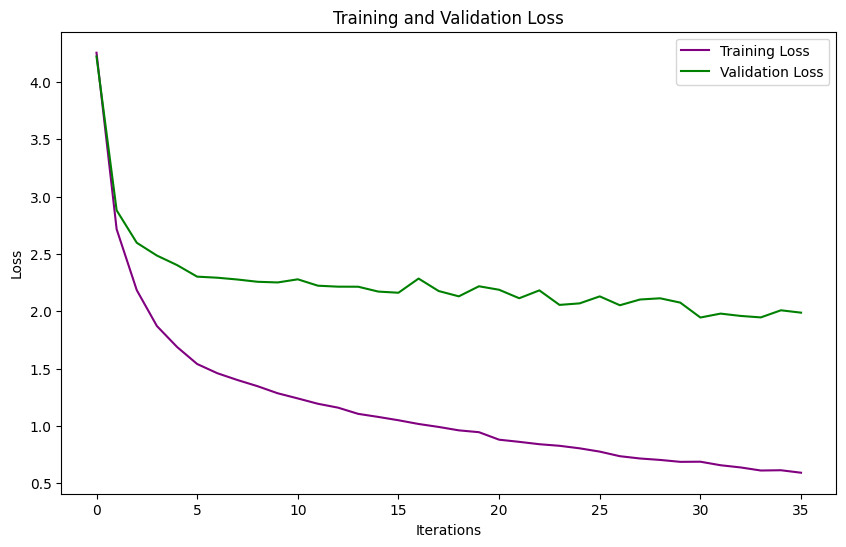

In [71]:
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss', color='purple')
plt.plot(val_losses, label='Validation Loss', color='green')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [25]:
def separate(s):
    stack = []
    sections = []
    for i, c in enumerate(s):
        if c in ['(', '[']:
            stack.append((c, i))
        elif c in [')', ']']:
            while stack:
                opening, start = stack[-1]  # Peek at the top of the stack
                if (opening == '(' and c == ')') or (opening == '[' and c == ']'):
                    stack.pop()  # Remove the matching opening bracket
                    sections.append((start, i))
                    break
                else:
                    stack.pop()  # Remove the non-matching opening bracket

    # Filter out overlapping sections
    non_overlapping_sections = []
    last_end = -1
    for start, end in sorted(sections, key=lambda x: x[0]):
        if start > last_end:
            non_overlapping_sections.append((start, end))
            last_end = end

    return non_overlapping_sections


def show_sections(s, sections):
    all_sections = []
    last_end = 0  # To keep track of the last section's end index

    for start, end in sections:
        if start > last_end:
            # Add the section between the last end and this start
            all_sections.append(s[last_end:start])
        # Add the section within the current parenthesis/bracket
        all_sections.append(s[start:end+1])
        last_end = end + 1  # Update the last end index

    # Handle any remaining section after the last parenthesis/bracket
    if last_end < len(s):
        all_sections.append(s[last_end:])

    return all_sections

smiles = smiles 
s = smiles[0]
sections = separate(s)
all_sections = show_sections(s, sections)
" ".join(all_sections)

'CC (C) (C) c1ccc2occ (CC(=O)Nc3ccccc3F) c2c1\n'

In [49]:
smiles_1 = pd.read_csv('smile_3.csv')
smiles = smiles_1['canonical_smiles']

In [52]:
text = ""

for i in tqdm(range(len(smiles))):
    sections = separate(smiles[i])
    all_sections = show_sections(smiles[i], sections)
    text += " ".join(all_sections)
    text += "* "

100%|██████████| 52/52 [00:00<00:00, 14027.77it/s]


In [53]:
text = text.replace("\n", "")

print(text)

CC (C) CN (Sc1ccc2c(c1)CCO2) [C@H] (CO) CCCCNC (=O) [C@@H] (Cc1cccc2ccccc12) NC (=O) N1CCOCC1* CC (C) CN (Sc1ccc2c(c1)OCCO2) [C@H] (CO) CCCCNC (=O) [C@@H] (Cc1cccc2ccccc12) NC (=O) N1CCOCC1* CC (C) CN ([C@H](CO)CCCCNC(=O)[C@H](Cc1ccccc1Br)NC(=O)N1CCOCC1) S (=O) (=O) c1ccc2c (c1) CCO2* Cc1c (O) cccc1C (=O) N [C@@H] (Cc1ccccc1Br) C (=O) NCCCC [C@@H] (CO) N (CC(C)C) S (=O) (=O) c1ccc (N) cc1* CC (C) CN ([C@H](CO)CCCCNC(=O)[C@H](Cc1ccccc1Br)NC(=O)c1cccc(=O)[nH]1) S (=O) (=O) c1ccc (N) cc1* Cc1ccccc1C [C@H] (NC(=O)c1cccnc1) C (=O) NCCCC [C@@H] (CO) N (CC(C)C) S (=O) (=O) c1ccc (N) cc1* O=C (O) CNC (=O) c1c (=O) oc (O) c2cc (Br) ccc12* C [C@H] (NC(=O)c1c(=O)oc(O)c2cccc(-c3cccc(C(F)(F)F)c3)c12) C (=O) O* Cc1ccccc1C [C@H] (NC(=O)c1cccc(C)c1O) C (=O) NCCCC [C@@H] (CO) N (CC(C)C) S (=O) (=O) c1ccc (N) cc1* COC (=O) N [C@@H] (CC1CCCCC1) C (=O) NCCCC [C@@H] (CO) N (CC(C)C) S (=O) (=O) c1ccc (N) cc1* CC (C) CN ([C@H](CO)CCCCNC(=O)[C@H](CC1CCCCC1)NC(=O)c1cccnc1) S (=O) (=O) c1ccc (N) cc1* Cc1ccc (C(

In [79]:
val = vocab.decode(m.generate(context, max_new_tokens=2000)[0].tolist())

In [80]:
print(val)

 c1ccc (N) cc1* CCC (C) CN ([C@H](CO)CCCCNC(=O)[C@@@H](CC1cccc2ccc2Br)C(=O)NCCCC[C@@H](CO)Cc1ccnC(C)I)C)S(=O)(=O)c1ccc(N)cc1)COC (c1ccccc1) S (=O) (=O) c1cc (N) ccc1* CCC (=O) N [C@@H] (Cc1cccc1Br) C (=O) NCCCCC [C@@@H] (CO) N (CC(C)C) S (=O) (=O) c1cc (N) ccc1* CC (C) CN ([C@H](d=O)CCCCN=C1)C(c1ccccc1)Br)NC(=O)OCC1=CC1) S (=O) (=O) c1ccc (N) cc1* CC (C) CN ([C@H](CO)CCCCNC(=O)[C@@H](Cc1ccccc1Br)NC(=O)c1cnnc(c1)cc1)cc2) S (=O) (=O2ccccc (N) ccc12* COC (=O) CNC (=O) [C@H] (Cc1ccccnc1) CC (C) ) (c1ccccc1) c1OOc1OC (=O) NCCCC [C@@@H] (Cc1ccccc1Br) CC (=O) NCCC (=O) N [C@@@H] (2cccc(2ccccccccc2Br)C(=O)c1cccnc1) C (c1cccc1) CN1C (=OCC1* COC [C@@H] (CO) CCCCNC (=O) [C@@@H] (CCCNC(=O)C(Cc1ccccc1)Br)lc1cccc(c1)OC+) S (=O) (=O) c1ccc (N) cc1* COC [C@@H] (Cc1ccccc1Br) C (=O) NCCCC [C@@@H] (CO) N (CC(C)C) S (=O) (=O) c1ccc (N) cc1* COC (=O) N [C@@H] (Cc1C2cccccc12cccccn1) C (=O) o ( c1O* Cc1ccc (C(=O)NCCCCC [C@@@H](CO)CC(C(N)C(=O)N)[C1CCOCC1)CC(Br)O) S (=O) (=O) c1ccc (N) cc1* CC (C) CN ([C@H](CO

In [81]:
new = "".join(val)
new = new.split('*')

new = [s for s in new if len(s) > 2]

new = [s.replace(' ', '') for s in new]
new

['c1ccc(N)cc1',
 'CCC(C)CN([C@H](CO)CCCCNC(=O)[C@@@H](CC1cccc2ccc2Br)C(=O)NCCCC[C@@H](CO)Cc1ccnC(C)I)C)S(=O)(=O)c1ccc(N)cc1)COC(c1ccccc1)S(=O)(=O)c1cc(N)ccc1',
 'CCC(=O)N[C@@H](Cc1cccc1Br)C(=O)NCCCCC[C@@@H](CO)N(CC(C)C)S(=O)(=O)c1cc(N)ccc1',
 'CC(C)CN([C@H](d=O)CCCCN=C1)C(c1ccccc1)Br)NC(=O)OCC1=CC1)S(=O)(=O)c1ccc(N)cc1',
 'CC(C)CN([C@H](CO)CCCCNC(=O)[C@@H](Cc1ccccc1Br)NC(=O)c1cnnc(c1)cc1)cc2)S(=O)(=O2ccccc(N)ccc12',
 'COC(=O)CNC(=O)[C@H](Cc1ccccnc1)CC(C))(c1ccccc1)c1OOc1OC(=O)NCCCC[C@@@H](Cc1ccccc1Br)CC(=O)NCCC(=O)N[C@@@H](2cccc(2ccccccccc2Br)C(=O)c1cccnc1)C(c1cccc1)CN1C(=OCC1',
 'COC[C@@H](CO)CCCCNC(=O)[C@@@H](CCCNC(=O)C(Cc1ccccc1)Br)lc1cccc(c1)OC+)S(=O)(=O)c1ccc(N)cc1',
 'COC[C@@H](Cc1ccccc1Br)C(=O)NCCCC[C@@@H](CO)N(CC(C)C)S(=O)(=O)c1ccc(N)cc1',
 'COC(=O)N[C@@H](Cc1C2cccccc12cccccn1)C(=O)o(c1O',
 'Cc1ccc(C(=O)NCCCCC[C@@@H](CO)CC(C(N)C(=O)N)[C1CCOCC1)CC(Br)O)S(=O)(=O)c1ccc(N)cc1',
 'CC(C)CN([C@H](CO)CCCCNC(=O)=O)S(=O)(=O)c1ccc(N)cc1',
 'CC(C)CN([C@H](CO)CCCCNC(=O)NC[C@@@H](Cc1ccccc2cc

[04:33:54] SMILES Parse Error: syntax error while parsing: CCC(C)CN([C@H](CO)CCCCNC(=O)[C@@@H](CC1cccc2ccc2Br)C(=O)NCCCC[C@@H](CO)Cc1ccnC(C)I)C)S(=O)(=O)c1ccc(N)cc1)COC(c1ccccc1)S(=O)(=O)c1cc(N)ccc1
[04:33:54] SMILES Parse Error: Failed parsing SMILES 'CCC(C)CN([C@H](CO)CCCCNC(=O)[C@@@H](CC1cccc2ccc2Br)C(=O)NCCCC[C@@H](CO)Cc1ccnC(C)I)C)S(=O)(=O)c1ccc(N)cc1)COC(c1ccccc1)S(=O)(=O)c1cc(N)ccc1' for input: 'CCC(C)CN([C@H](CO)CCCCNC(=O)[C@@@H](CC1cccc2ccc2Br)C(=O)NCCCC[C@@H](CO)Cc1ccnC(C)I)C)S(=O)(=O)c1ccc(N)cc1)COC(c1ccccc1)S(=O)(=O)c1cc(N)ccc1'
[04:33:54] SMILES Parse Error: syntax error while parsing: CCC(=O)N[C@@H](Cc1cccc1Br)C(=O)NCCCCC[C@@@H](CO)N(CC(C)C)S(=O)(=O)c1cc(N)ccc1
[04:33:54] SMILES Parse Error: Failed parsing SMILES 'CCC(=O)N[C@@H](Cc1cccc1Br)C(=O)NCCCCC[C@@@H](CO)N(CC(C)C)S(=O)(=O)c1cc(N)ccc1' for input: 'CCC(=O)N[C@@H](Cc1cccc1Br)C(=O)NCCCCC[C@@@H](CO)N(CC(C)C)S(=O)(=O)c1cc(N)ccc1'
[04:33:54] SMILES Parse Error: syntax error while parsing: CC(C)CN([C@H](d=O)CCCCN=C1)C(c1cc

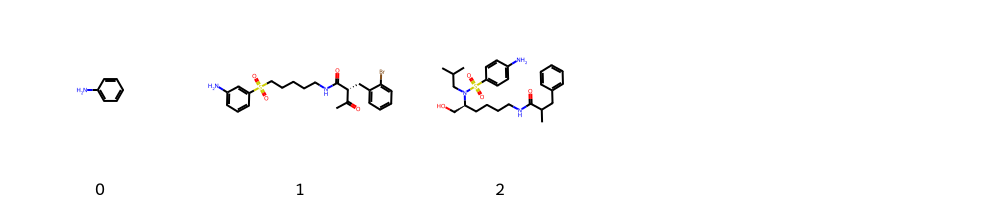

In [82]:
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole


mols = [Chem.MolFromSmiles(smi) for smi in new if Chem.MolFromSmiles(smi) is not None]
Draw.MolsToGridImage(mols, molsPerRow=5, subImgSize=(200, 200), legends=[str(i) for i in range(len(mols))])

In [72]:
model_state_path = "Only3_BPC.pkl"
torch.save(model.state_dict(), model_state_path)

print("Model saved successfully.")

Model saved successfully.
